# <center> Отчёт по проекту <br> "Идентификация пользователей по посещенным веб-страницам"


### Цели и задачи проекта
Целью данного проекта являлась идентификация пользователя по его поведению в сети Интернет.
Для достижения поставленной цели предполагалось решить следующие задачи:
* Подготовка данных к анализу и построению моделей
* Первичный анализ данных, проверка гипотез
* Визуальный анализ данных
* Построение признаков
* Выбор модели, построение кривых валидации и обучения
* Опробация классификатора в соревновании Kaggle Inclass по идентификации пользователей: настройка параметров и построение добавочных признаков
* Blending
* Дополнительно - применение Vowpal Wabbit к данным по посещению сайтов

### Описание исходных данных
В работе были использованы данные с прокси-серверов Университета Блеза Паскаля [1], имеющие следующий вид: для каждого пользователя заведен csv-файл с названием user****.csv

(где вместо звездочек – 4 цифры, соответствующие ID пользователя), а в нем посещения сайтов записаны в следующем формате: 
<center>*timestamp, посещенный веб-сайт* </center>

Выборка по 10 пользователям была использована для написания и отладки кода,  в качестве рабочей выборки была использована выборка по 150 пользователям.

Для участия в соревновании kaggle по идентификации пользователя Элис [2] были использованы данные с тех же серверов в виде .csv файлов с обучающей и с тестовой выборкой.


### Подготовка данных к анализу и построению моделей
Поставим задачу классификации: идентифицировать пользователя по сессии из 10 подряд посещенных сайтов. Объектом в этой задаче будет сессия из 10 сайтов, последовательно посещенных одним и тем же пользователем, признаками – индексы этих 10 сайтов. Целевым классом будет id пользователя.
Для решения задачи была реализована функция, которая принимает на вход путь к каталогу с csv-файлами path_to_csv_files и параметр session_length – длину сессии, а возвращает 2 объекта: DataFrame, в котором строки соответствуют уникальным сессиям из session_length сайтов, session_length столбцов – индексам этих session_length сайтов и последний столбец – ID пользователя (Таблица 1), и
частотный словарь сайтов вида {'site_string': [site_id, site_freq]}. 
Если сессия оказалась короче 10 сайтов, оставшиеся позиции были заполнены нулями.


In [2]:
from IPython.display import Image

Таблица 1. Пример DataFrame, в котором строки соответствуют уникальным сессиям из session_length сайтов, session_length столбцов – индексам этих session_length сайтов и последний столбец – ID пользователя.

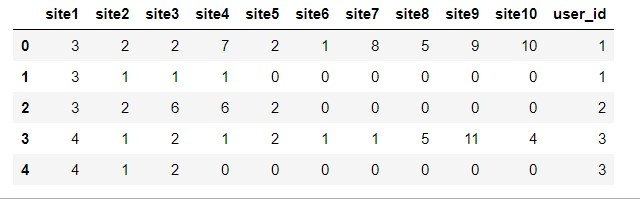

In [8]:
Image(filename = '01_frame.jpg')

Далее, воспользовавшись идеей "мешка слов", с помощью разреженных матриц Scipy  мы создали новые матрицы, в которых строкам соответствуют сессии из 10 сайтов, а столбцам – индексы сайтов (столбец, соответствующий сайту с индексом 0 - индикатору коротких сессий, был удален). На пересечении строки  𝑖  и столбца  𝑗  стоит число  𝑛𝑖𝑗  – cколько раз сайт  𝑗  встретился в сессии номер  𝑖  [3]. 

Также было создано 16 дополнительных обучающих выборок, где длина сессии составляла 5, 7, 10 и 15 сайтов, а ширина окна (сессии могли перекрываться) - 5, 7 и 10 сайтов. Полученные данные для 10 и 150 пользователей были сохранены с  помощью pickle (сериализации в Python).

### Первичный анализ данных, проверка гипотез

Для выборки 10 пользователей мы имеем 14061 сессию. 
Распределение целевого класса по пользователям:
128:    2796,
39:    2204,
207:    1868,
127:    1712,
237:   1643,
33:     1022,
50:      802,
31:      760,
100:     720,
241:     534.

 На рисунке 1 приведено распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов. Распределение этой величины не является нормальным, что подтверждают построенный QQ-плот и проверка с помощью критерия Шапиро-Уилка (p-value < 0.05).
 
Также можно отвергнуть гипотезу о том, что доля случаев, когда пользователь хотя бы раз зайдет на сайт, который он уже ранее посетил в сессии из 10 сайтов, равна 95 %,  в пользу односторонней альтернативы (доля таких случаев больше 95 %) с помощью биномиального критерия для доли (p-value = 0.022). 95% доверительный интервал Уилсона для доли случаев, когда пользователь повторно посетил какой-то сайт - [0.95, 0.957].

Рис. 1. Распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов.

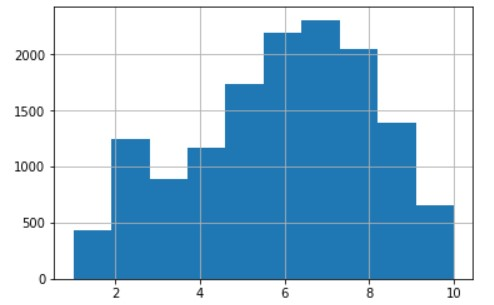

In [5]:
Image(filename = '012_usites.jpg')

### Визуальный анализ данных и построение признаков

Для основной выборки, соответствующей 10 пользователям, были построены следующие признаки:
- 'session_timespan' – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- '#unique_sites' – число уникальных сайтов в сессии 
- 'start_hour' – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- 'day_of_week' – день недели (то есть день недели в записи минимального timestamp среди десяти) 
- 'youtube_portion' -  признак, характеризующий склонность смотреть видео на youtube (здесь рассчитывается доля сайтов в сессии, содержащих комбинацию 'youtube' в адресе )
- 'time' - время суток начала сессии: утро (с 7 до 11 часов), день (с 12 до 17 часов), вечер (с 18 до 23 часов) (строится на основе признака start_hour)

 Для каждого признака были построены гистограммы распределения, которые приведены на рисунке 2.

Рис. 2. Гистограмма распределения построенных признаков. Гистограмма распределения признака 'session_timespan' (длина сессии) построена для всех пользователей, гистограммы распределения остальных признаков - для каждого из 10 пользователей. Id пользователей заменены человеческими именами.

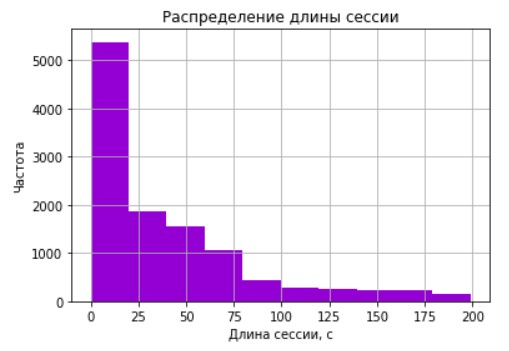

In [6]:
Image(filename = '020_st.jpg')

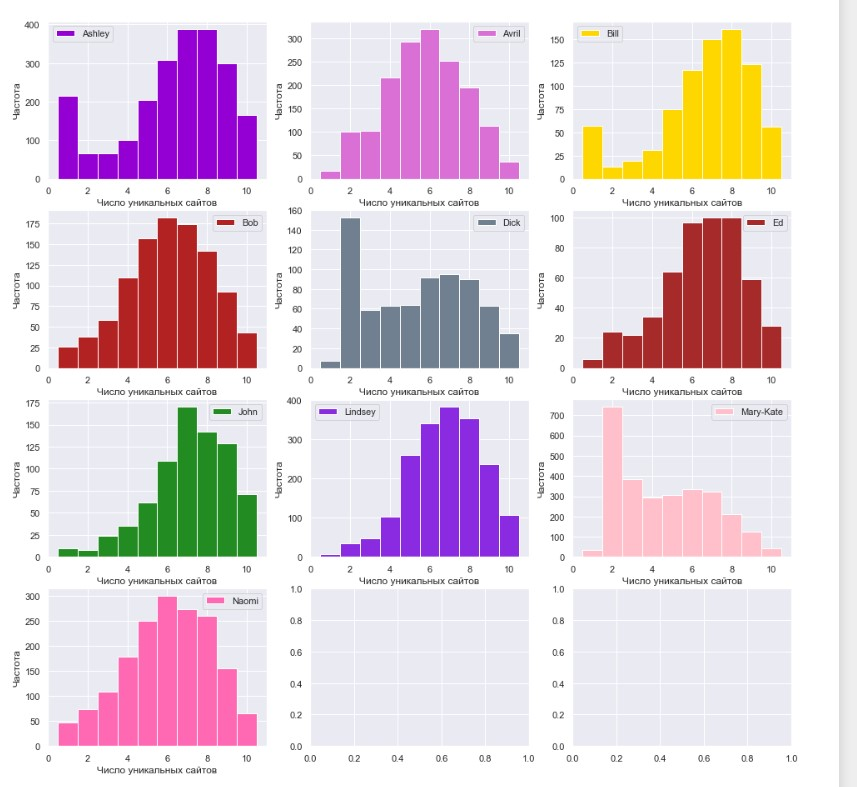

In [7]:
Image(filename = '021_us.jpg')

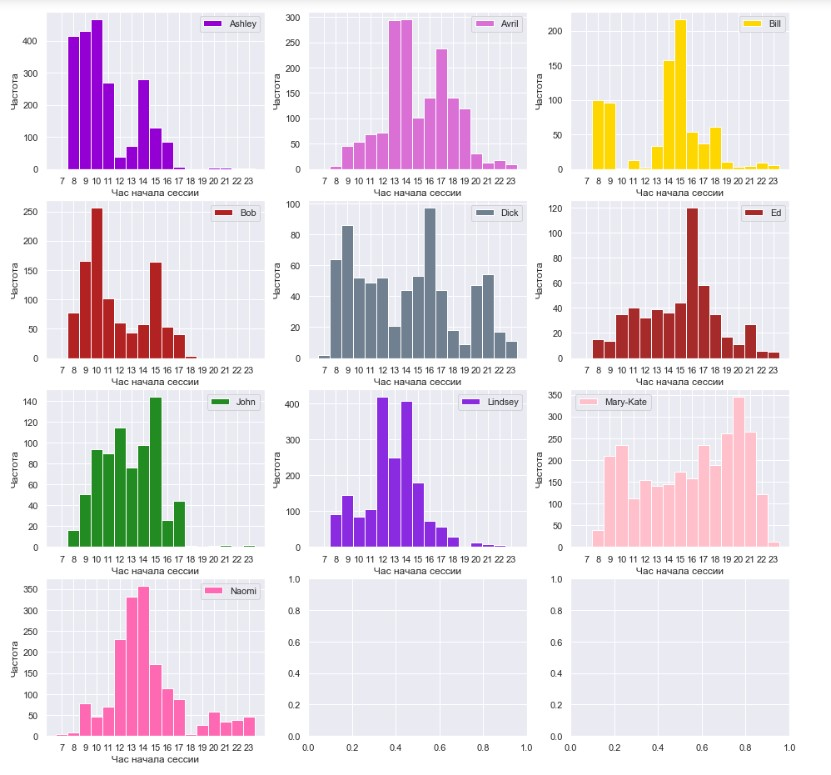

In [8]:
Image(filename = '020_sh.jpg')

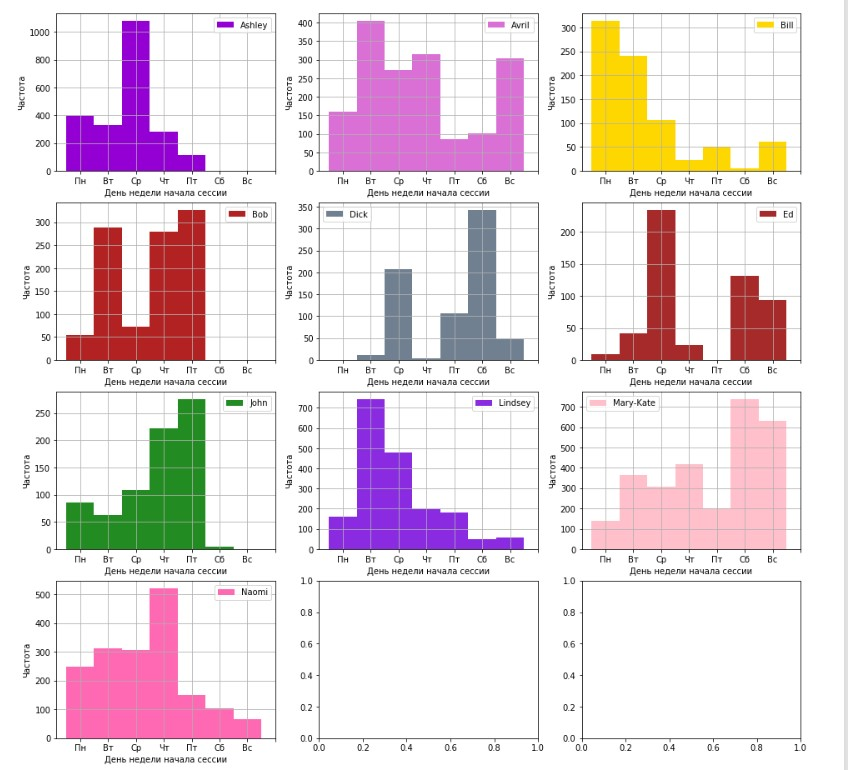

In [9]:
Image(filename = '02_weekday.jpg')

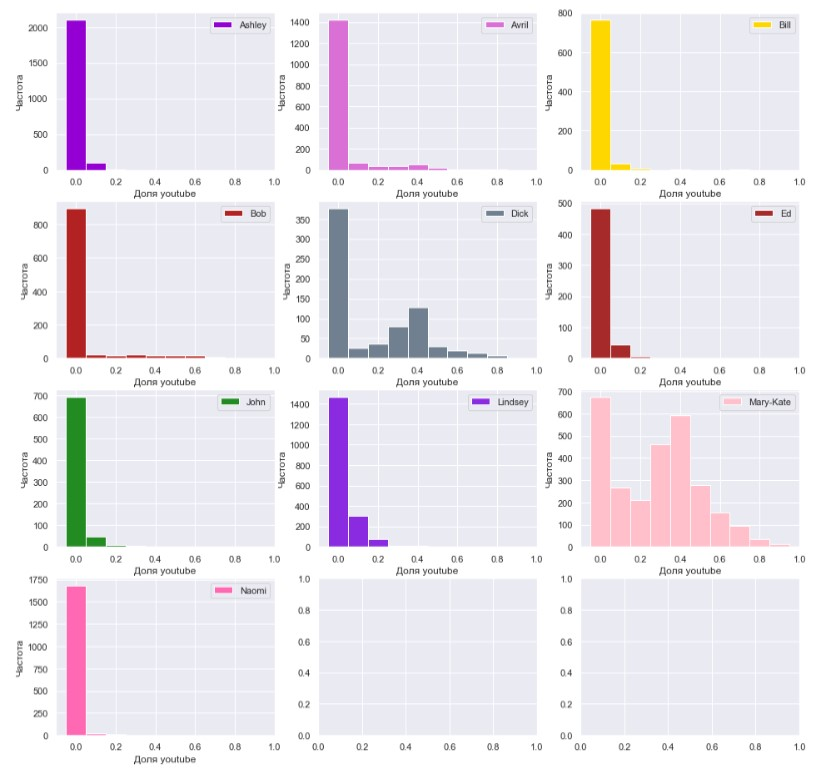

In [9]:
Image(filename = '020_yt.jpg')

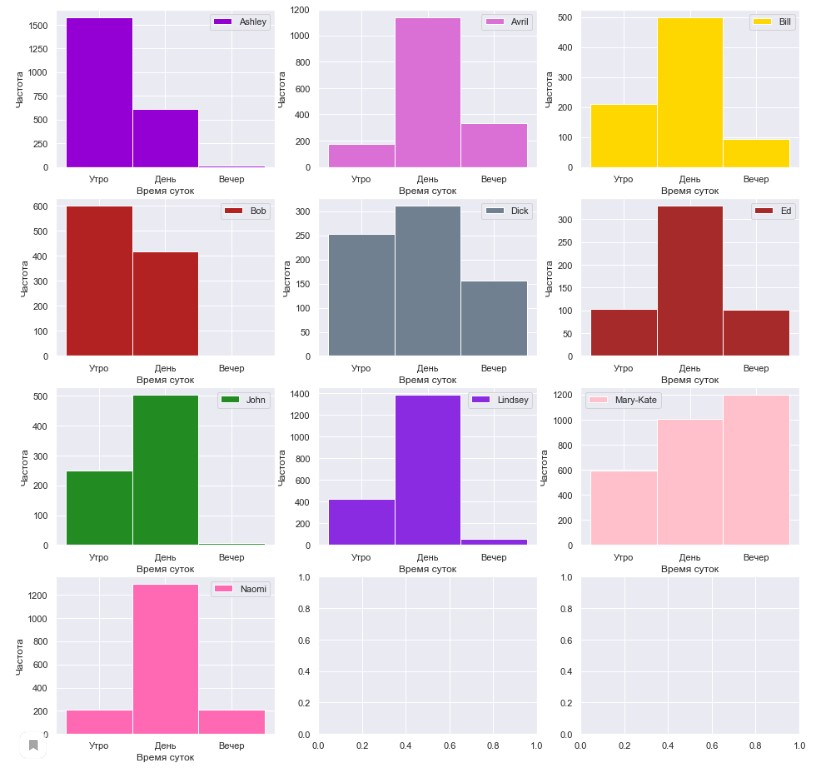

In [10]:
Image(filename = '020_t.jpg')

<b>Выводы.</b> 

Для начала отметим, что все пользователи не начинают сессии ночью (возможно, администрация Университета отключала студентам интернет).  Минимальный и максимальный час начала сессии - 7 и 23, соответственно. Почти все сессии длятся меньше 3 минут.

По числу уникальных сайтов пользователи похожи, признак информативен в небольшой степени. 

У некоторых пользователей ярко выражены предпочтения по дням недели для выхода в Интернет. 

В целом, пользователи начинают интернет-сессии преимущественно в  дневное время, но распределения признака для каждого пользователя отличаются. 

Также удалось выявить 2-х пользователей, имеющих значительную долю просмотра youtube-сайтов в сессии (Mary-Kate и Dick).

Общий вывод - каждый пользователь имеет свой уникальный профиль взаимодействия с Интернетом.

### Выбор модели, построение кривых валидации и обучения

Для выборки из 10 пользователей было проведено сравнение нескольких алгоритмов на кросс-валидации и отложенной выборке (Таблица 2). Была использована трехкратная кросс-валидация с перемешиванием, размер отложенной выборки - 30%.
Наилучшее качество на кросс-валидации показал линейный SVM с параметром регуляризации C = 0.104 (Соответствует максимуму на кривой валидации (test), рис. 3).

Таблица 2. Доля правильных ответов для алгоритмов с параметрами по умолчанию и с настроенным параметром регуляризации на кросс-валидации и отложенной выборке.

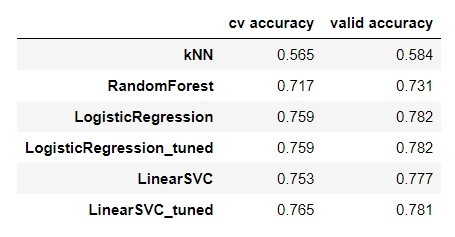

In [15]:
Image(filename = '03_table.jpg')

Рис. 3. Кривые валидации при настройке линейного SVM (Linear_SVC_tuned).

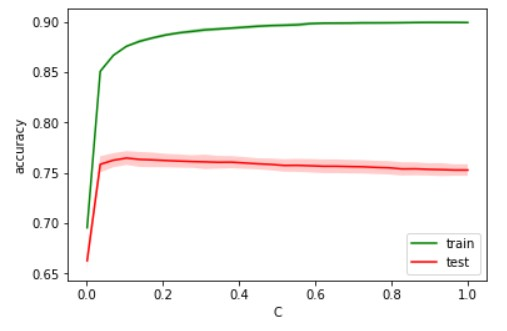

In [21]:
Image(filename = '031_v_curves.jpg')

Также было исследовано качество классификации Linear_SVC_tuned в зависимости от длины сессии (session_lenghth) и ширины окна(window_size). Для 10 пользователей качество достигает максимума при(session_length, window_size) = (15,5): 0.868 и 0.875 на кросс-валидации и на отложенной выборке, соответственно. 
Для 150 пользователей расчёт доли правильных ответов на кросс-валидации и отложенной выборке был проведен для сочетаний параметров (session_length, window_size): (5,5), (7,7) и (10,10). С увеличением параметров session_length и window_size качество классификации возрастает. Наилучшее качество было достигнуто для параметров (session_length, window_size) = (10,10): 0.461 и 0.484, соответственно.

Для 150 пользователей (размер выборки - 137019 сессий) была решена задача идентификации конкретного пользователя ("Один-против-Всех"), алгоритм  Linear_SVC_tuned. На рисунке 4 приведены кривые обучения. По мере роста числа обучающих данных качество классификации на тестовой выборке быстро становится постоянным, следовательно, новые размеченные данные алгоритму не помогут.

Рис. 4. Кривые обучения для задачи идентификации одного пользователя.

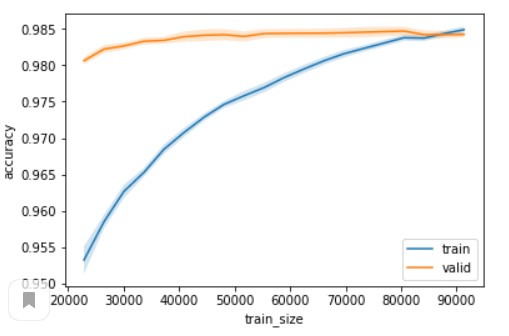

In [17]:
Image(filename = '04_learning_curves.jpg')

### Опробация классификатора в соревновании: настройка параметров и построение добавочных признаков

В обучающей выборке видим следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - user_id – ID пользователя
    
Сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут. В обучающей выборке – 2297 сессий идентифицируемого пользователя Элис (маркировка класса -1) и 251264 сессий – других пользователей (маркировка класс - 0). Вследствие сильного дисбаланса классов для оценки качества классификации была использована метрика ROC AUC.
Индексы пропущенных сайтов в коротких сессиях были заменены на 0, затем данные были переведены в разреженный формат.

Для участия  в соревновании в качестве baseline-модели был использован классификатор на основе стохастического градиентного спуска с логистической функцией потерь (остальные параметры - по умолчанию). Оценка его качества по метрике ROC AUC на отложенной выборке (30% от обучающей) - 0.934, на тесте Kaggle - 0.913.
Настройка параметра регуляризации SGDClassifier не дала улучшения на тесте, результат - 0.912. Также были испробованы другие классификаторы, настроенные MultinomialNB и LogisticRegression, но их качество на тесте составило 0.878 и 0.906, соответственно. Поэтому в качестве рабочей модели был использован baseline- классификатор.


Далее была проведена работа с признаками. Для начала в данные были добавлены 9 столбцов, характеризующие разницу во времени между посещениями сайтов в сессии (time_diffN, где N = 1...9), затем обновленные данные были переведены в разреженный формат. Качество улучшить не удалось - оно составило 0.906, следовательно, от добавления этих признаков в  данные пришлось отказаться.
Тогда для данных были построены ранее рассмотренные признаки: 'day_of_week', 'start_hour', 'session_timespan', '#unique_sites', 'time', а также признаки 'month' и 'year', характеризующие месяц и год начала сессии.

Нам еще нужно было учесть индивидуальные предпочтения пользователя Элис при посещения сайтов. Для этого был составлен словарь (id сайта - частота появления сайта в сессии) для Элис, и такой же словарь для остальных пользователей. Были выявлены top10 сайтов для Элис (куда могут входить сайты из top10 других пользователей) и выявлены те сайты из top20 Элис, в которые не входят сайты из top20 других пользователей, то есть сайты, предпочтительные только для Элис (получилось 10 сайтов). В данные были добавлены соответствующие признаки: 'top10_Alice_freq' - частота появления сайтов из top10 Alice в сессии (Рис. 5), 'top20_onlyAlice_freq' - частота появления сайтов из top20 Alice, не входящих в top20 остальных (Рис.6).

Рис. 5. Распределение частоты появления сайтов из top10 Элис для Элис и для остальных пользователей.

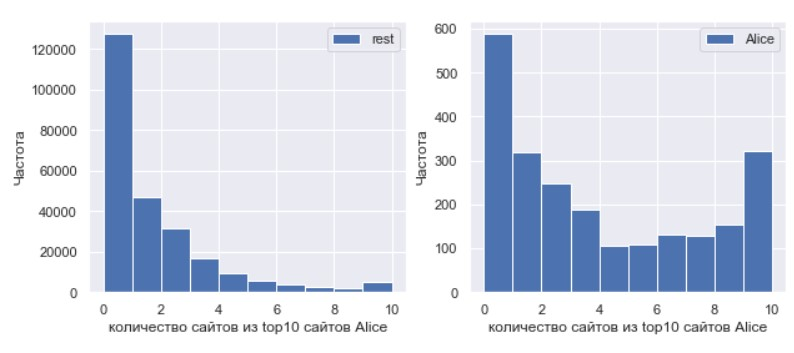

In [19]:
Image(filename = '05_top10.jpg')

Рис. 6. Распределение частоты появления сайтов из top20 Элис, не входящих в top20 остальных пользователей, для Элис и для остальных пользователей.

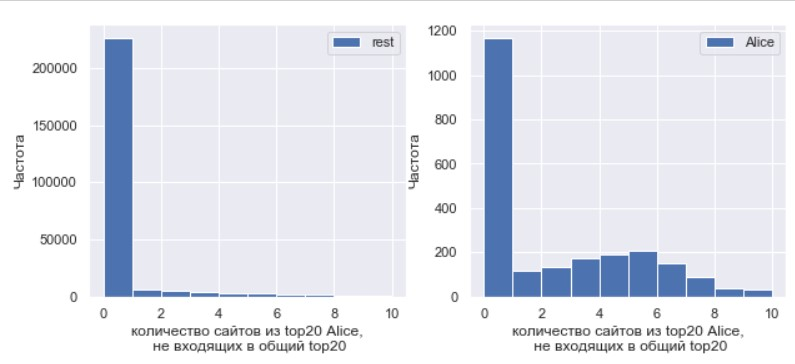

In [20]:
Image(filename = '06_top20onlyAlice.jpg')

Затем категориальные признаки были обработаны OneHotEncoder, вещественные - масштабированы. Добавление признаков улучшило результат на тесте kaggle - 0.939.

### Blending
Далее была сделана попытка улучшить качество с помощью техники blending, идеи для реализации были взяты из тьюториала [4]. К базовому алгоритму были добавлены 2 алгоритма, основанные на градиентном бустинге: GradientBoostingClassifier(n_estimators = 200, max_depth = 5, random_state=17) и GradientBoostingClassifier(n_estimators = 50, max_depth = 8, random_state=17) и ещё один SGDClassifier, отличающийся от baseline способом регуляризации - 'elasticnet' (линейная комбинация L1 и L2 регуляризации) и параметром alpha = 0.000008. Точность этих алгоритмов на отложенной выборке составила 0.977, 0.970, 0.955 и 0.984, соответственно. Оказалось, что коэффициенты взаимной корреляции предсказаний выбранных алгоритмов не превышают 0.84, поэтому были использованы все алгоритмы. Мета-алгоритмом послужила логистическая регрессия с параметром C = 1.1. 
Blending улучшил результат baseline-алгоритма на тесте всего на 0.001. Но зато мы обнаружили, что смена способа регуляризации baseline-алгоритма на 'elasticnet' + настройка параметра регуляризации увеличивает его ROC AUC на отложенной выборке. Результат на kaggle: 0.945.

### Заключение
Итак, мы получили ROC AUC 0.945 с помощью добавления новых признаков и настройки параметров baseline модели. Существенно улучшить качество с помощью техники blending не удалось. В качестве дальнейшего улучшения можно обрабатывать сессии, например, с помощью TF-IDF подхода.

Построенная модель может быть применена для выявления хакеров и других потенциальных злоумышленников сети Интернет; выявления студентов или сотрудников компаний, проявляющих интерес к сайтам, призывающим к экстремизму, межнациональной розни, суициду и др.

В бизнесе модель может решать задачу сбора данных об интересах конкретных пользователей на основе посещенных ими сайтов; а также задачу понимания способов взаимодействия пользователей с интернет-сервисами для улучшения этих сервисов. 

А ещё - в задании предложено проявлять фантазию - по скорости перехода между сайтами; форме, содержанию и количеству запрашиваемой информации; ритмам суточной, недельной и сезонной активности можно определять психологические/ценностные характеристики пользователей и использовать эту информацию в своих целях.

Использованные источники:

[1] https://drive.google.com/file/d/11AqEDEITiodB8fcB8IZvp_5odfZuqAsS/view

[2] https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/data

[3] https://towardsdatascience.com/handling-sparse-matrix-concept-behind-compressed-sparse-row-csr-matrix-4fe6abe58a7a

[4] https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_russian/tutorials/tutorial_ensemble_methods_qovaxx.ipynb

### Приложение. Применение Vowpal Wabbit к данным по посещению сайтов

В рамках знакомства c библиотекой Vowpal Wabbit была проведена классификация пользователей на 400 классов в соревновании kaggle.  В полученной обучающей выборке (тот же формат данных, что и в задаче идентификации пользователя Элис) мы имеем 182793 сессий, в тестовой – 46473, и сессии действительно принадлежат 400 различным пользователям. Тестовые сессии по времени четко отделены от сессий в обучающей выборке. 

Исходные данные были предобработаны - выбраны только столбцы с id-сайтов, пропуски заменены нулями, затем данные были переведены в разреженный формат. Метки классов были обработаны с помощью LabelEncoder и переведены в диапазон от 1 до K. Далее была написана и применена функция, приводящая данные к формату .vw.

Затем модель Vowpal Wabbit была обучена с параметрами: --oaa 400, -c, -k, --passes 3, -b 26, --random_seed 17. Функцию потерь сначала задавали по умолчанию (squared), затем использовали SVM (hinge) и логистическую (logistic) функцию. В таблице приведено время обучения и точность модели на отложенной выборке и тесте Kaggle в сравнении c  SGDClassifier и с логистической регрессией.


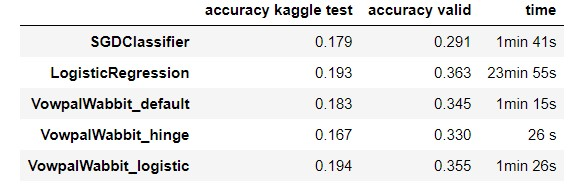

In [3]:
Image(filename = '07_vw.jpg')

Из таблицы видно,  VowpalWabbit модель с функцией потерь, заданной по умолчанию, на тесте Kaggle имеет качество чуть хуже, чем LogisticRegression, но обучается намного быстрее. Она же имеет лучшее качество и обучается быстрее, чем SGDClassifier.  VowpalWabbit_hinge модель обладает самой высокой скоростью обучения, но ее качество самое низкое среди рассмотренных моделей.  А если задать логистическую функцию потерь, то vw-модель и по качеству на тесте Kaggle не уступает логистической регрессии.

Нельзя сказать, что рассмотренная задача решается достаточно хорошо. Возможно, построение добавочных признаков и тщательный подбор параметров позволит улучшить качество, но, судя по значениям верхних позиций Лидерборда соревнования, несущественно.